In [1]:
from collections import defaultdict
from functools import partial
import numpy as np
import os
import pandas as pd
from pandas import IndexSlice as ix
import pycountry

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 1
%aimport util

save_fig = partial(util.save_fig, save=True)

In [2]:
dataset_raw = pd.read_csv(util.RAW_DATASET)

In [3]:
def common_name(country):
    try:
        return country.common_name
    except AttributeError:
        return country.name

### Rafiq et al. (2016): 22 "increasingly urbanized emerging economies"

In [4]:
rafiq2016_table2 = """Angola
Costa Rica
Ghana
Indonesia
Lebanon
Mongolia
Namibia
Panama
Sudan
Thailand
Zambia
Bangladesh
China
Ethiopia
India
Jordan
Malaysia
Mozambique
Nigeria
Singapore
Tanzania
Vietnam
"""

records = [pycountry.countries.get(name=x) 
           or pycountry.countries.get(common_name=x) 
           for x in rafiq2016_table2.strip().split('\n')]
assert all(x is not None for x in records)
records = sorted(records, key=common_name)
rafiq2016_codes = [x.alpha_3 for x in records]
repr(rafiq2016_codes)

"['AGO', 'BGD', 'CHN', 'CRI', 'ETH', 'GHA', 'IND', 'IDN', 'JOR', 'LBN', 'MYS', 'MNG', 'MOZ', 'NAM', 'NGA', 'PAN', 'SGP', 'SDN', 'TZA', 'THA', 'VNM', 'ZMB']"

In [5]:
assert util.RAFIQ2016_COUNTRIES == rafiq2016_codes

### Tiba and Frikha (2018): middle-income countries (minus Venezuela)

In [6]:
tiba2018_middle = """
Algeria
Argentina
Brazil
Bulgaria
Chile
China
Colombia
Malaysia
Mexico
Thailand
Turkey
Venezuela
"""

records = [pycountry.countries.get(name=x) 
           or pycountry.countries.get(common_name=x) 
           for x in tiba2018_middle.strip().split('\n')]
assert all(x is not None for x in records)
records = sorted(records, key=common_name)
tiba2018_middle_codes = [x.alpha_3 for x in records]
repr(tiba2018_middle_codes)

"['DZA', 'ARG', 'BRA', 'BGR', 'CHL', 'CHN', 'COL', 'MYS', 'MEX', 'THA', 'TUR', 'VEN']"

In [7]:
assert util.TIBA2018_MID_COUNTRIES == tiba2018_middle_codes

### Tiba and Frikha (2018): high-income countries

In [8]:
tiba2018_high = """
Australia
Canada
France
Germany
Japan
Netherlands
Portugal
Spain
Sweden
Switzerland
United Kingdom
United States
"""

records = [pycountry.countries.get(name=x) 
           or pycountry.countries.get(common_name=x) 
           for x in tiba2018_high.strip().split('\n')]
assert all(x is not None for x in records)
records = sorted(records, key=common_name)
tiba2018_high_codes = [x.alpha_3 for x in records]
repr(tiba2018_high_codes)

"['AUS', 'CAN', 'FRA', 'DEU', 'JPN', 'NLD', 'PRT', 'ESP', 'SWE', 'CHE', 'GBR', 'USA']"

In [9]:
assert util.TIBA2018_HIGH_COUNTRIES == tiba2018_high_codes

## Extract contiguous panel sets

In [10]:
dataset_raw = pd.read_csv(util.RAW_DATASET, index_col=['Country', 'Year'])

In [11]:
dataset_raw

ENI         POP     URB          AFL        TI        TS  \
Country Year                                                             
ABW     1980  NaN  333.866667  50.472          NaN       NaN       NaN   
        1981  NaN  336.483333  50.456          NaN       NaN       NaN   
        1982  NaN  340.805556  50.441          NaN       NaN       NaN   
        1983  NaN  345.561111  50.426          NaN       NaN       NaN   
        1984  NaN  349.088889  50.411          NaN       NaN       NaN   
...           ...         ...     ...          ...       ...       ...   
ZWE     2015  NaN   35.710557  32.385  2679.510136  0.202684  0.567488   
        2016  NaN   36.268295  32.296  2806.458631  0.092656  0.512190   
        2017  NaN   36.801719  32.237  3028.245976       NaN  0.500283   
        2018  NaN   37.324591  32.209  3203.888554       NaN  0.500054   
        2019  NaN         NaN  32.210  2953.484113       NaN       NaN   

                   CTS    KAOPEN  
Country Year                      
ABW     1980       NaN       NaN  
        1981       NaN       NaN  
        1982       NaN       NaN  
        1983       NaN       NaN  
        1984       NaN       NaN  
...                ...       ...  
ZWE     2015  0.029254 -0.148388  
        2016  0.024596 -0.148388  
        2017  0.022614 -0.148388  
        2018  0.022107 -0.148388  
        2019       NaN       NaN  

[8692 rows x 8 columns]

In [12]:
dataset = dataset_raw.loc[ix[util.ALL_COUNTRIES, 1990:2015], :].sort_index()
def find_years(x):
    return ','.join(map(str, x.index.get_level_values('Year')))

missing = dataset.stack(dropna=False).isnull()
missing.loc[missing].groupby(level=[0,2]).aggregate(find_years)

Country        
ALB      ENI                           2015
         TI             1990,1991,1992,2012
         KAOPEN    1990,1991,1992,1993,1994
ARG      ENI                           2015
ARM      ENI                           2015
                             ...           
ZAF      ENI                           2015
ZMB      ENI                      2014,2015
         TI             1994,1997,1998,2000
         TS             1990,1991,1992,1993
         CTS            1990,1991,1992,1993
Length: 164, dtype: object

In [13]:
for c, df in dataset.groupby(level='Country'):
    df_not_na = df.dropna(axis='rows', how='any')
    years = df_not_na.index.get_level_values('Year')
    contiguous_years = range(years[0], years[-1]+1)
    if any(years != contiguous_years):
        missing = set(contiguous_years) - set(years)
        print('%s %s' % (c, missing))


ALB {2012}
ARM {2004}
AZE {2000, 1997, 1998, 1999}
CYP {1993, 1994, 1995, 1996, 1997, 1998}
DZA {2008, 2009}
ECU {2011, 2012}
EGY {1997}
HND {1993, 1994, 1997, 2003, 2004}
IDN {2012}
IRN {1992, 1991}
JAM {1998, 1999}
KAZ {2012}
KEN {1992, 1994, 1995, 2000, 2001}
MAR {1992, 2001, 2003, 1999}
MLT {2003, 2005}
PAN {1997, 1998, 1999}
PER {1995, 1998}
PRY {1991, 1994, 1995, 1996, 1997, 1998, 1999}
SAU {2008, 2009, 2012}
TJK {2008, 2007}
TZA {2012}
URY {2013}
VEN {2001, 1995, 1998, 1999}
ZMB {2000, 1997, 1998}


In [14]:
country_years = defaultdict(lambda:(1990,2015), {
    **{x:(1990,2014) for x in ['ARG', 'BRA', 'CHN', 'DZA', 'MYS', 'THA']},
    'AUS': (1995,2015),
    'BGR': (1994,2014),
    'CHE': (1996,2014),
    'COL': (1994,2014),
    'VEN': (2002,2011),
})
country_years = {c: country_years[c] for c in util.SUBSET_COUNTRIES}
data_subset = pd.concat([dataset.loc[ix[c, start:end], :]
                        for c, (start, end) in country_years.items()]).sort_index()
assert set(data_subset.index.get_level_values('Country')) == set(util.SUBSET_COUNTRIES)

In [15]:
missing = data_subset.stack(dropna=False).isnull()
missing.loc[missing].groupby(level=[0,2]).aggregate(find_years)

Country    
DZA      TI    2008,2009
dtype: object

In [16]:
def get_date(code):
    start, end = country_years[code]
    return '%s-%s' % (start, end)
    
def sorted_names(codes, date_fn):
    name_map = {common_name(pycountry.countries.get(alpha_3=code)):code  for code in codes}
    names = sorted(name_map.keys())
    dates = map(date_fn, (name_map[name] for name in names))
    return pd.DataFrame({'Country': names, 'Date range': dates})

print(sorted_names(tiba2018_middle_codes, get_date).to_latex(index=False))
print(sorted_names(tiba2018_high_codes, get_date).to_latex(index=False))


\begin{tabular}{ll}
\toprule
   Country & Date range \\
\midrule
   Algeria &  1990-2014 \\
 Argentina &  1990-2014 \\
    Brazil &  1990-2014 \\
  Bulgaria &  1994-2014 \\
     Chile &  1990-2015 \\
     China &  1990-2014 \\
  Colombia &  1994-2014 \\
  Malaysia &  1990-2014 \\
    Mexico &  1990-2015 \\
  Thailand &  1990-2014 \\
    Turkey &  1990-2015 \\
 Venezuela &  2002-2011 \\
\bottomrule
\end{tabular}

\begin{tabular}{ll}
\toprule
        Country & Date range \\
\midrule
      Australia &  1995-2015 \\
         Canada &  1990-2015 \\
         France &  1990-2015 \\
        Germany &  1990-2015 \\
          Japan &  1990-2015 \\
    Netherlands &  1990-2015 \\
       Portugal &  1990-2015 \\
          Spain &  1990-2015 \\
         Sweden &  1990-2015 \\
    Switzerland &  1996-2014 \\
 United Kingdom &  1990-2015 \\
  United States &  1990-2015 \\
\bottomrule
\end{tabular}



## Save out subset data

In [17]:
data_subset.to_csv(util.DATASET_SUBSET)

## Extract full country panel

In [18]:
from bisect import bisect_left
from itertools import product
def sequence(df):
    years = df.index.get_level_values('Year')
    best = 0, None, None
    curr, start, end = 1, years[0], years[0]
    for i in years[1:]:
        if i == end + 1:
            curr, end = curr + 1, i
        else:
            if curr > best[0]:
                best = curr, start, end
            curr, start, end = 1, i, i
    if curr > best[0]:
        best = curr, start, end
    return pd.Series(best, index=['length', 'start', 'end'])

sequences = (
    dataset_raw.dropna(how='any')
    .sort_index()
    .groupby(level='Country')
    .apply(sequence)
    .sort_values('length', ascending=False)
)
t10 = sequences.query('length >= 10')
t10.head()
# sequence(pd.DataFrame({'val':0.}, index=pd.MultiIndex.from_tuples(product(['a'], [2,3,4,6,7,8,9,10,12,13,14]), names=['Country Code', 'Year'])))

,length,start,end
Country,,,
FIN,26,1990,2015
ISR,26,1990,2015
DEU,26,1990,2015
FRA,26,1990,2015
GBR,26,1990,2015


In [19]:
[k for k in util.RAFIQ2016_COUNTRIES if k not in t10.index]

['AGO', 'CRI', 'ETH', 'GHA', 'LBN', 'MNG', 'NAM', 'NGA', 'SDN']

In [20]:
t10.start.max(), t10.end.min()

(2005, 2002)

In [21]:
display(t10.sort_values('start').tail())
display(t10.sort_values('end').head())

,length,start,end
Country,,,
VEN,10,2002,2011
KEN,13,2002,2014
MAR,11,2004,2014
ARM,10,2005,2014
HND,10,2005,2014


,length,start,end
Country,,,
MLT,13,1990,2002
TJK,10,1997,2006
SAU,18,1990,2007
DZA,18,1990,2007
PRY,11,2000,2010


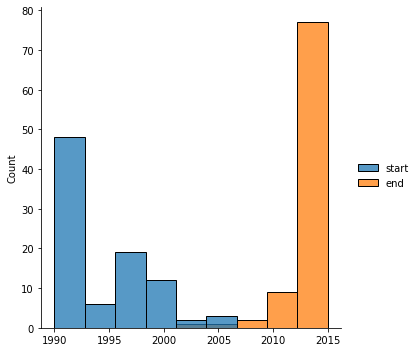

In [22]:
sns.displot(t10[['start', 'end']])

In [23]:
repr(sorted(t10.index))

"['ALB', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BEL', 'BGD', 'BGR', 'BLR', 'BRA', 'CAN', 'CHE', 'CHL', 'CHN', 'COL', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GEO', 'GRC', 'GTM', 'HKG', 'HND', 'HRV', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KOR', 'LKA', 'LTU', 'LVA', 'MAR', 'MDA', 'MEX', 'MKD', 'MLT', 'MOZ', 'MYS', 'NLD', 'NOR', 'NZL', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRT', 'PRY', 'ROU', 'RUS', 'SAU', 'SGP', 'SVK', 'SVN', 'SWE', 'THA', 'TJK', 'TUN', 'TUR', 'TZA', 'UKR', 'URY', 'USA', 'UZB', 'VEN', 'VNM', 'ZAF', 'ZMB']"

In [24]:
def t10_date(code):
    start, end = t10.loc[code, ['start', 'end']]
    return '%s-%s' % (start, end)

print(sorted_names(t10.index, t10_date).to_latex(index=False))

\begin{tabular}{ll}
\toprule
                   Country & Date range \\
\midrule
                   Albania &  1995-2011 \\
                   Algeria &  1990-2007 \\
                 Argentina &  1990-2014 \\
                   Armenia &  2005-2014 \\
                 Australia &  1995-2015 \\
                   Austria &  1990-2015 \\
                Azerbaijan &  2001-2014 \\
                Bangladesh &  1990-2014 \\
                   Belarus &  1996-2014 \\
                   Belgium &  2000-2015 \\
                    Brazil &  1990-2014 \\
                  Bulgaria &  1994-2014 \\
                    Canada &  1990-2015 \\
                     Chile &  1990-2015 \\
                     China &  1990-2014 \\
                  Colombia &  1991-2014 \\
                   Croatia &  1996-2014 \\
                    Cyprus &  1999-2014 \\
                   Czechia &  1996-2015 \\
                   Denmark &  1990-2015 \\
        Dominican Republic &  2000-2014 \\
                

In [25]:
data_fullset = pd.concat([dataset_raw.loc[ix[c, x.start:x.end], :]
                          for c, x in t10.iterrows()]).sort_index()
assert set(data_fullset.index.get_level_values('Country')) == set(util.ALL_COUNTRIES)

In [26]:
data_fullset.to_csv(util.DATASET_ALL)